In [420]:
a = np.array([[1,2,3,4],
              [5,6,7,8]])
b = a.T
print(a.shape, b.shape)
np.dot(a,b).shape

(2, 4) (4, 2)


(2, 2)

In [462]:
import numpy as np
import scipy as sp
from scipy.stats import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import math
% matplotlib inline

sns.set()
class multivariate_student_t():
    
    def __init__(self, mu, lam, nu):
        try:
            self.D = mu.shape[0]
        except AttributeError:
            self.D = 1
        if self.D>1:
            self.mu = mu
            if len(self.mu.reshape(-1))!=D:
                sys.exit("parametor 'mu' must be vector!")
            if lam.shape[0]!=lam.shape[1]:
                sys.exit("expect lam.shape[0] == lam.shape[1], Actual:{}!={}".format(lam.shape[0],lam.shape[1]))
            self.lam = lam
        else:
            if lam <= 0:
                sys.exit("parametor 'lam' must > 0")
            self.mu = mu
            self.lam = lam
        if nu<=0:
            sys.exit("parametor 'nu' must > 0")
        self.nu = nu

    def pdf(self, x):
        member1 = np.exp(math.lgamma((self.nu+self.D)*0.5)-math.lgamma(self.nu*0.5))

        if self.D==1:
            _x = x.reshape(1,-1)
            member2 = np.sqrt(self.lam/(math.pi*self.nu))
            member3 = (1+self.lam/self.nu*np.square(_x-self.mu))**(-(self.nu+1)*0.5)
        else:
            _x = x.reshape(-1, self.D)
            self.mu = self.mu.reshape(1, self.D)
            member2 = np.sqrt(np.linalg.det(self.lam))/(math.pi*self.nu)**(0.5*self.D)
            member3 = []
            for a in _x:
                member3 += [1 + np.dot(np.dot(a-self.mu, self.lam),  (a-self.mu).T)/self.nu]
            member3 = np.array(member3)[:,0]
            print("member3 shape:",member3.shape)
            member3 = member3**(-(self.nu+self.D)*0.5)
            
            
        _y = member1 * member2 * member3
        return _y

        
def student(x, mu, lm, nu):
    gamma_1 = sp.special.gamma((nu+1)*0.5)
    gamma_2 = sp.special.gamma(nu*0.5)
    y = gamma_1/gamma_2*np.sqrt(lm/(nu*np.pi))*((1+lm/nu*np.square(x-mu))**(-(nu+1)*0.5))
    
    return y


def draw_data_distribution(data_size, parametors,
                           ax=None,
                           color="skyblue",
                           distribution="norm",
                           graph_label="data distribution",
                           title = "data distribution",
                           need_data = False,
                           seed=0):
    np.random.seed(seed)
    multi = False
    if distribution=="norm":
        print("generate gaussian distribution, loc={}, scale={}".format(parametors[0],parametors[1]))
        x_data = np.random.normal(parametors[0], 1/parametors[1], data_size)
    if ax is None:
        figure = plt.figure(figsize=(6,4))
        ax = figure.add_subplot(1,1,1)
        ax.hist(x_data, bins=30, density=True ,color=color, label=graph_label)

        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("probability-density")
        ax.legend()

    else:
        ax.hist(x_data, bins=30, density=True ,ec=color, label=graph_label, fill=False)
        ax.legend()
    if need_data:
        return ax, x_data
    else:
        return ax
    
def draw_function(parametors,
                  ax=None,
                  color="skyblue",
                  draw_range=None,
                  distribution="gauss",
                  label_prefix="",
                  title = "estimate distribution",
                  seed=0):
    disp_param = [round(param, 2) for param in parametors]
    if distribution=="gauss":
        print("drawing {} graph, loc={} scale={}".format(distribution, parametors[0], parametors[1]))
        graph_label= label_prefix + "{} μ={}, σ={}".format(distribution, disp_param[0], disp_param[1])
        if draw_range is None:
            draw_range = (parametors[0]-3*parametors[1], parametors[0]+3*parametors[1])
        x = np.linspace(draw_range[0], draw_range[1],1000)
        y = norm.pdf(x, loc=parametors[0], scale=1/parametors[1])
    elif distribution=="gamma":
        print("drawing {} graph, a={} b={}".format(distribution, parametors[0], parametors[1]))
        graph_label= label_prefix + "{} a={}, b={}".format(distribution, disp_param[0], disp_param[1])
        if draw_range is None:
            draw_range=(0,10)
        x = np.linspace(draw_range[0], draw_range[1], 1000)
        y = gamma.pdf(x, a=parametors[0], scale=1/parametors[1])
    elif distribution == "student":
        print("drawing student's T graph, μ={}, λ={}, ν={}".format(parametors[0],parametors[1], parametors[2]))
        graph_label = label_prefix + "{} μ={}, λ={}, ν={}".format(distribution, disp_param[0], disp_param[1], disp_param[2])
        if draw_range is None:
            draw_range = (parametors[0]-5, parametors[0]+5)
        x = np.linspace(draw_range[0], draw_range[1], 1000)
        y = t.pdf(x, parametors[2], loc=parametors[0], scale=1/np.sqrt(parametors[1]))
        
    if ax is None:
        figure = plt.figure(figsize=(6,4))
        ax = figure.add_subplot(1,1,1)
        ax.plot(x,y,color=color, label=graph_label)
        
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel(title)
        ax.legend()

    else:
        ax.plot(x,y,color=color, label=graph_label)
        ax.legend()
        
    return ax

def draw_3d_distribution(data_size, parametors,
                         distribution="norm",
                         need_data = False,
                         cmap=None,
                         ax=None,
                         label_prefix="",
                         title="data distribution",
                         seed=0):
    np.random.seed(seed)
    if distribution=="norm":
        mean = parametors[0]
        sigma = np.linalg.inv(parametors[1])
        print("-----------------------------------------")
        print("generate multi-gaussian distribution")
        print("loc=",parametors[0])
        print("scale=",parametors[1])
        print("ndim={}".format(parametors[1].shape[0]))
        graph_label = label_prefix + " multi-gauss loc=[{},{}], sigma=[[{},{}],[{},{}]]".format(mean[0],mean[1],sigma[0,0],sigma[0,1],sigma[1,0],sigma[1,1])
        x1 = np.linspace(mean[0]-4*sigma[0,0], mean[0]+4*sigma[0,0], data_size)
        x2 = np.linspace(mean[1]-4*sigma[1,1], mean[1]+4*sigma[1,1], data_size)
        X1, X2 = np.meshgrid(x1, x2)
        X = np.c_[np.ravel(X1), np.ravel(X2)]
        x_data = multivariate_normal.pdf(x=X, mean=mean, cov=sigma)
    elif distribution == "student":
        mu = parametors[0]
        lam = parametors[1]
        nu = parametors[2]
        print("-----------------------------------------")
        print("generate multi-student's t distribution")
        print("μ:")
        print(mu)
        print("Λ:")
        print(lam)
        print("ν:")
        print(nu)
        print("ndim={}".format(lam.shape[0]))
        _t = multivariate_student_t(mu, lam, nu)
        x1 = np.linspace(mu[0]-5, mu[0]+5, data_size)
        x2 = np.linspace(mu[1]-5, mu[1]+5, data_size)
        X1, X2 = np.meshgrid(x1, x2)
        X = np.c_[np.ravel(X1), np.ravel(X2)]
        x_data = _t.pdf(x=X)
        
    if ax is None:
        figure = plt.figure(figsize=(12,8))
        ax = figure.add_subplot(111,projection='3d')
        ax.plot_surface(X1, X2, x_data.reshape(X1.shape), cmap=cmap, linewidth=0)
        ax.set_title(title)
            
    else:
        ax.plot_wireframe(X1, X2, x_data.reshape(X1.shape), color=cmap,linewidth=0.5)
    if need_data:
        return ax, x_data
    else:
        return ax

### 平均の推定

drawing gauss graph, loc=0.0 scale=1.0
drawing gauss graph, loc=95.16944180248967 scale=21.0
post loc :95.16944180248967 scale:0.047619047619047616
generate gaussian distribution, loc=100, scale=0.2
drawing gauss graph, loc=0.0 scale=0.16666666666666669
drawing gauss graph, loc=95.16944180248967 scale=0.19811320754716982


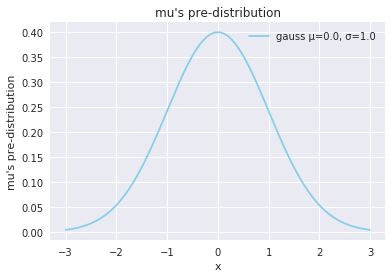

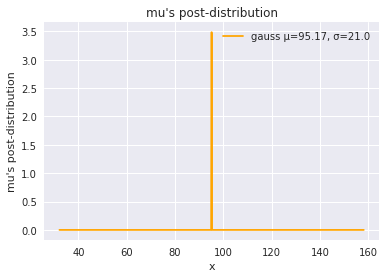

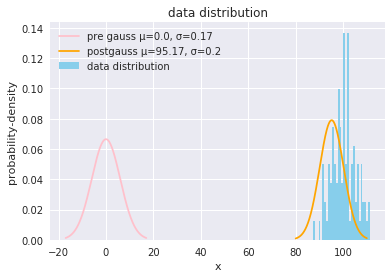

In [277]:
pre_mu_loc = 0.
pre_mu_scale_inv = 1.
real_mu = 100
real_scale_inv = 0.2
data_size = 100

x_data = np.random.normal(real_mu, 1/real_scale_inv, data_size)

est_mu_scale_inv = data_size*real_scale_inv + pre_mu_scale_inv
est_mu_loc = (real_scale_inv*np.sum(x_data)+pre_mu_scale_inv*pre_mu_loc)/est_mu_scale_inv

draw_function((pre_mu_loc, pre_mu_scale_inv),
              title="mu's pre-distribution")

draw_function((est_mu_loc, est_mu_scale_inv),
              color="orange", 
              title="mu's post-distribution")

print("post loc :{} scale:{}".format(est_mu_loc, 1/est_mu_scale))

est_data_mu = pre_mu_loc
est_data_scale_inv = real_scale_inv*pre_mu_scale/(real_scale_inv+pre_mu_scale)

ax1 = draw_data_distribution(data_size, (real_mu, real_scale_inv))

draw_range=(int(est_data_mu-3/est_data_scale_inv), int(est_data_mu+3/est_data_scale_inv))
ax1=draw_function((est_data_mu,est_data_scale_inv),
                  draw_range=draw_range,
                  ax=ax1, 
                  label_prefix="pre ",
                  color="pink")

est_data_mu = est_mu_loc
est_data_scale_inv = real_scale_inv*est_mu_scale/(real_scale_inv+est_mu_scale)
draw_range=(int(est_data_mu-3/est_data_scale_inv), int(est_data_mu+3/est_data_scale_inv))
draw_function((est_data_mu, est_data_scale_inv),
              draw_range=draw_range,
              ax=ax1,
              label_prefix="post",
              color="orange")

### 精度の推定

- draw student T's distribution
- text book ⇔ scipy notion:
    $$μ⇔loc$$
    $$λ⇔\frac{2}{scale},\quad λ^{-\frac{1}{2}} ⇔ scale $$
    $$ν⇔{first\quad argument, (df)}$$

drawing student's T graph, μ=0, λ=1, ν=1
drawing student's T graph, μ=0, λ=1, ν=4
drawing student's T graph, μ=0, λ=4, ν=1


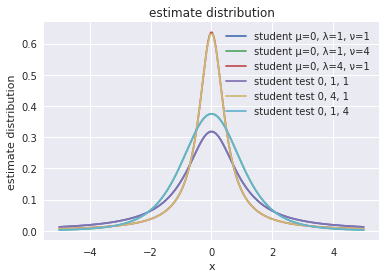

In [402]:
parametors=(0,1,1)
ax = draw_function(parametors, color=None, distribution="student")
parametors=(0,1,4)
ax = draw_function(parametors, color=None, ax=ax, distribution="student")
parametors=(0,4,1)
ax = draw_function(parametors, color=None, ax=ax, distribution="student")

# 順に次のものと同じ
# y = t.pdf(x, 1,0,1)
# ax.plot(x,y, label="student test 0, 1, 1")
# y = t.pdf(x, 4,0,1)
# ax.plot(x,y, label="student test 0, 4, 1")
# y = t.pdf(x, 1,0,0.5)
# ax.plot(x,y, label="student test 0, 1, 4")
# plt.legend()
x = np.linspace(-5,5,100)
_t = multivariate_student_t(0,1,1)
y = _t.pdf(x)
ax.plot(x,y, label="student test 0, 1, 1")
_t = multivariate_student_t(0,4,1)
y = _t.pdf(x)
ax.plot(x,y, label="student test 0, 4, 1")
_t = multivariate_student_t(0,1,4)
y = _t.pdf(x)
ax.plot(x,y, label="student test 0, 1, 4")
plt.legend()


drawing gamma graph, a=1.0 b=1.0
generate gaussian distribution, loc=5, scale=5.0
drawing student's T graph, μ=5, λ=1.0, ν=2.0
drawing gamma graph, a=501.0 b=12049.443988721603
drawing student's T graph, μ=5, λ=0.041578682009638025, ν=1002.0


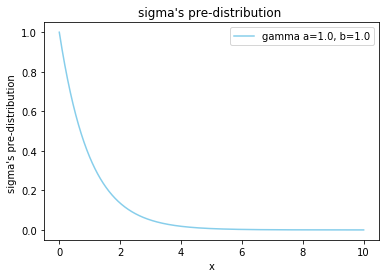

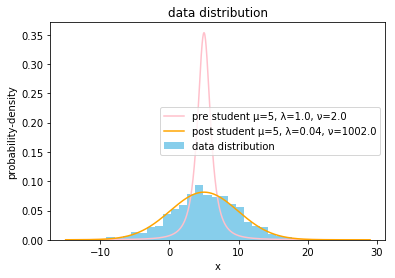

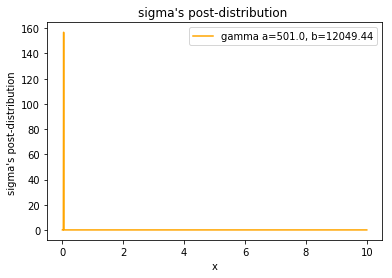

In [259]:
pre_sigma_a = 1.
pre_sigma_b = 1.
real_mu = 5
real_scale_inv = 0.2
data_size = 1000

graph_title="sigma's pre-distribution "
draw_function((pre_sigma_a, pre_sigma_b),
              distribution="gamma",
              title=graph_title)

ax1, x_data = draw_data_distribution(data_size,(real_mu, 1/real_scale_inv),
                             need_data=True,
                             seed=1)
draw_range=(int(np.min(x_data)-5), int(np.max(x_data+5)))

est_data_mu = real_mu
pre_data_lm = pre_sigma_a/pre_sigma_b
pre_data_nu = 2*pre_sigma_a

draw_function((est_data_mu, pre_data_lm, pre_data_nu),
              color="pink",
              draw_range=draw_range,
              label_prefix="pre ",
              ax=ax1,
              distribution="student")


est_sigma_a = data_size/2 + pre_sigma_a
est_sigma_b = 0.5*np.sum((x_data-real_mu)**2)+pre_sigma_b

graph_title = "sigma's post-distribution "
draw_function((est_sigma_a, est_sigma_b),
              distribution="gamma",
              color="orange",
              title=graph_title)

est_data_lm = est_sigma_a/est_sigma_b
est_data_nu = 2*est_sigma_a


draw_function((est_data_mu, est_data_lm, est_data_nu),
              color="orange",
              draw_range=draw_range,
              label_prefix="post ",
              ax=ax1,
              distribution="student")


### 精度と平均共に未知

generate gaussian distribution, loc=5, scale=5.0
drawing student's T graph, μ=0.0, λ=0.5, ν=2.0
drawing student's T graph, μ=4.7689475150339895, λ=0.04105718854341546, ν=2.0


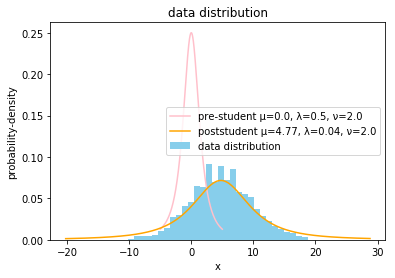

In [263]:
pre_sigma_a = 1.
pre_sigma_b = 1.
pre_mu_loc = 0.
pre_mu_beta = 1.
real_mu = 5
real_scale_inv = 0.2
data_size = 1000

ax, x_data = draw_data_distribution(data_size,(real_mu, 1/real_scale_inv), need_data=True)

pre_data_mu = pre_mu_loc
pre_data_lm = pre_mu_beta*pre_sigma_a/(pre_sigma_b*(1+pre_mu_beta))
pre_data_nu = 2*pre_sigma_a
ax = draw_function((pre_data_mu, pre_data_lm, pre_data_nu), distribution="student", label_prefix="pre-",ax=ax,color="pink")

# update mu's param
est_mu_beta = data_size + pre_mu_beta
est_mu_loc = 1/est_mu_beta*(np.sum(x_data)+pre_mu_loc*pre_mu_beta)

# update sigma's param
est_sigma_a = data_size*0.5 + pre_sigma_a
est_sigma_b = 0.5*(np.sum(x_data**2)+pre_mu_beta*pre_mu_loc**2-est_mu_beta*est_mu_loc**2)+pre_sigma_b

# update data
est_data_mu = est_mu_loc
est_data_lm = est_mu_beta*est_sigma_a/(est_sigma_b*(1+est_mu_beta))
est_data_nu = 2*pre_sigma_a


draw_range = (np.min(x_data)-10, np.max(x_data)+10)
draw_function((est_data_mu, est_data_lm, est_data_nu),
              draw_range=draw_range,
              label_prefix="post",
              ax=ax,
              color="orange",
              distribution="student")

### 多次元ガウス分布

#### まずは平均の推定

In [348]:
x = np.random.randn(10,3)
np.sum(x,axis=0)

array([4.06506088, 7.83943526, 3.42050551])

-----------------------------------------
generate multi-gaussian distribution
loc= [3 5]
scale= [[3 2]
 [2 5]]
ndim=2
x_data shape: (100, 2)
-----------------------------------------
generate multi-gaussian distribution
loc= [0 0]
scale= [[0.7 0.1]
 [0.1 0.8]]
ndim=2


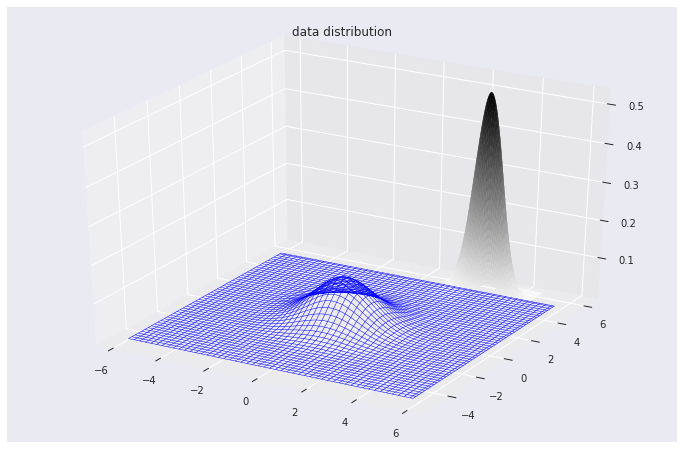

In [502]:
real_mu = np.array([3,5])
real_sigma_inv = np.array([[3,2],
                       [2,5]])
pre_mu_loc = np.array([0,0])
pre_mu_scale_inv = np.array([[1,0],
                             [0,1]])
data_size = 100

ax = draw_3d_distribution(data_size,(real_mu, real_sigma_inv),
                          distribution="norm",
                          cmap="gist_gray_r",
                          seed=3,
                          need_data=False)

x_data = np.random.multivariate_normal(mean=real_mu, cov=np.linalg.inv(real_sigma_inv), size=data_size)

print("x_data shape:",x_data.shape)

_m1 = np.linalg.inv(real_sigma_inv)
_m2 = np.linalg.inv(pre_mu_scale_inv)
est_data_sigma_inv = np.linalg.inv(_m1 + _m2)
est_data_mu = pre_mu_loc

draw_3d_distribution(data_size,(est_data_mu, est_data_sigma_inv),cmap="blue",ax=ax)

-----------------------------------------
generate multi-gaussian distribution
loc= [3 5]
scale= [[3 2]
 [2 5]]
ndim=2
(2, 2)
(2, 2)
-----------------------------------------
generate multi-gaussian distribution
loc= [3.07586168 4.93672136]
scale= [[2.97039462 1.9801982 ]
 [1.9801982  4.95059282]]
ndim=2


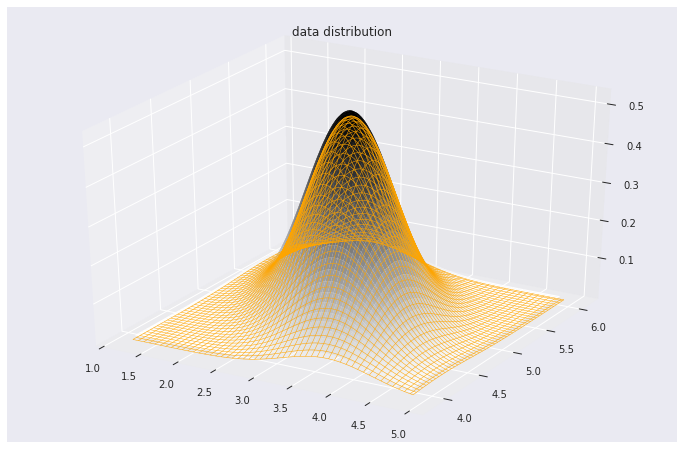

In [503]:
real_mu = np.array([3,5])
real_sigma_inv = np.array([[3,2],
                       [2,5]])
pre_mu_loc = np.array([0,0])
pre_mu_scale_inv = np.array([[1,0],
                             [0,1]])
data_size = 100

ax = draw_3d_distribution(data_size,(real_mu, real_sigma_inv),
                          distribution="norm",
                          cmap="gist_gray_r",
                          seed=3,
                          need_data=False)
est_mu_scale_inv = data_size*real_sigma_inv+pre_mu_scale_inv

_m1 = np.linalg.inv(est_mu_scale_inv)
_m2 = np.dot(real_sigma_inv,np.sum(x_data,axis=0).reshape(-1,1))+np.dot(pre_mu_scale_inv,pre_mu_loc.reshape(-1,1))

print(_axiom1.shape)
print(_axiom2.shape)
est_mu_loc = np.dot(_m1, _m2)

_m1 = np.linalg.inv(real_sigma_inv)
_m2 = np.linalg.inv(est_mu_scale_inv)
est_data_sigma_inv = np.linalg.inv(_m1 + _m2)
est_data_mu = est_mu_loc

draw_3d_distribution(data_size,(est_data_mu.reshape(-1), est_data_sigma_inv),cmap="orange",ax=ax)

#### 次いで精度の推定

In [368]:
a = np.array([[-2,-1,0,1,2],
          [2,1,0,-1,-2]])
np.cov(a,rowvar=2,bias=1)

array([[ 2., -2.],
       [-2.,  2.]])

-----------------------------------------
generate multi-gaussian distribution
loc= [3 5]
scale= [[3 2]
 [2 5]]
ndim=2
-----------------------------------------
generate multi-student's t distribution
μ:
[3 5]
Λ:
[[2 0]
 [0 2]]
ν:
2
ndim=2
member3 shape: (10000, 1)


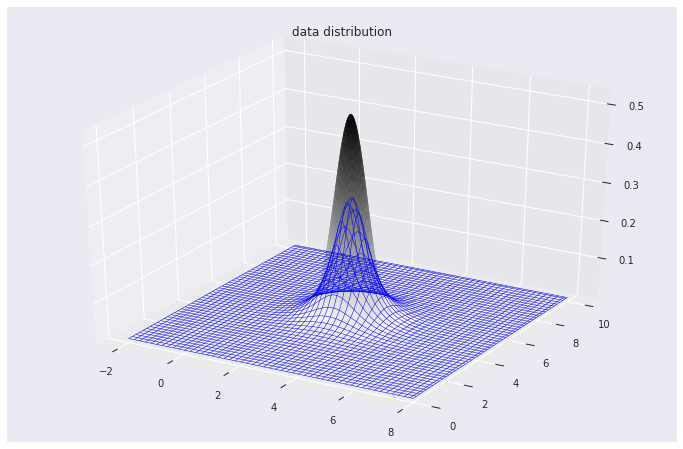

In [500]:
real_mu = np.array([3,5])
real_sigma_inv = np.array([[3,2],
                       [2,5]])
pre_sigma_nu = 3
pre_sigma_w = np.array([[1,0],
                        [0,1]])
data_size = 100
D = 2
ax = draw_3d_distribution(data_size,(real_mu, real_sigma_inv),
                          distribution="norm",
                          cmap="gist_gray_r",
                          seed=3,
                          need_data=False)

x_data = np.random.multivariate_normal(mean=real_mu, cov=np.linalg.inv(real_sigma_inv), size=data_size)

est_data_mu = real_mu
est_data_lam = (1-D+pre_sigma_nu)*pre_sigma_w
est_data_nu = 1-D+pre_sigma_nu

ax=draw_3d_distribution(data_size, (est_data_mu, est_data_lam, est_data_nu), ax=ax,cmap="blue",distribution="student")

-----------------------------------------
generate multi-gaussian distribution
loc= [3 5]
scale= [[3 2]
 [2 5]]
ndim=2
x_data shape: (100, 2)
w shape: (2, 2)
-----------------------------------------
generate multi-student's t distribution
μ:
[3 5]
Λ:
[[3.37455174 1.98908585]
 [1.98908585 4.61668221]]
ν:
102
ndim=2
member3 shape: (10000, 1)


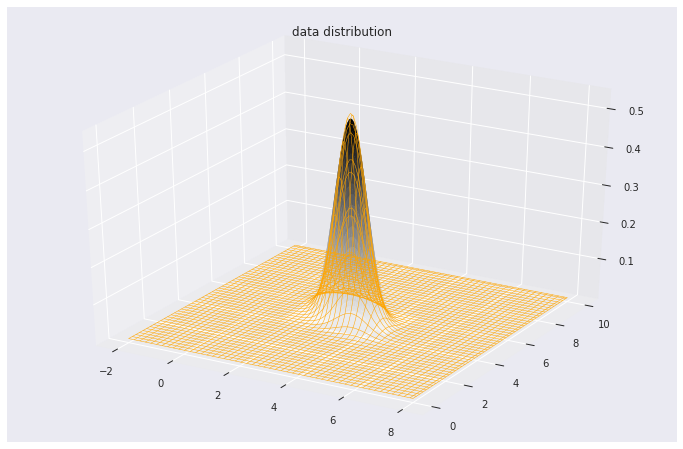

In [501]:
real_mu = np.array([3,5])
real_sigma_inv = np.array([[3,2],
                       [2,5]])
pre_sigma_nu = 3
pre_sigma_w = np.array([[1,0],
                        [0,1]])
data_size = 100
D = 2
ax = draw_3d_distribution(data_size,(real_mu, real_sigma_inv),
                          distribution="norm",
                          cmap="gist_gray_r",
                          seed=3,
                          need_data=False)

x_data = np.random.multivariate_normal(mean=real_mu, cov=np.linalg.inv(real_sigma_inv), size=data_size)

est_data_mu = real_mu
print("x_data shape:",x_data.shape)
est_sigma_w = np.linalg.inv(np.dot((x_data-real_mu).T,x_data-real_mu) + np.linalg.inv(pre_sigma_w))
est_sigma_nu = data_size + pre_sigma_nu
print("w shape:",est_sigma_w.shape)

est_data_lam = (1-D+est_sigma_nu)*est_sigma_w
est_data_nu = 1-D+est_sigma_nu

ax=draw_3d_distribution(data_size, (est_data_mu, est_data_lam, est_data_nu), ax=ax,cmap="orange",distribution="student")

#### 精度と平均が共に未知の場合の推定

-----------------------------------------
generate multi-gaussian distribution
loc= [3 5]
scale= [[10  2]
 [ 2  5]]
ndim=2
-----------------------------------------
generate multi-student's t distribution
μ:
[0 0]
Λ:
[[1. 0.]
 [0. 1.]]
ν:
2
ndim=2
member3 shape: (1000000, 1)


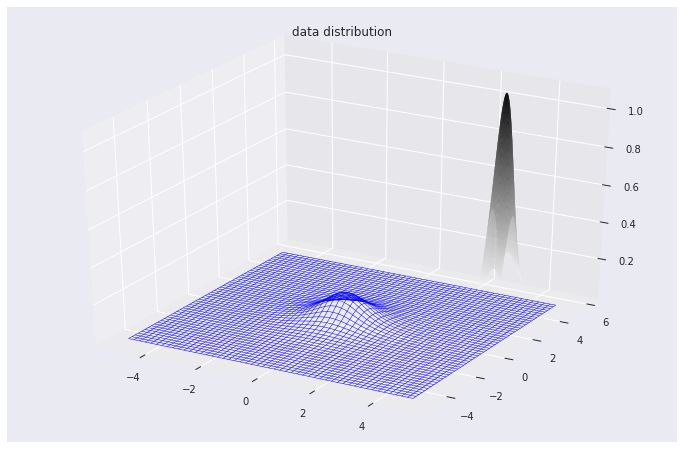

In [497]:
real_mu = np.array([3,5])
real_sigma_inv = np.array([[10,2],
                       [2,5]])
pre_sigma_nu = 3
pre_sigma_w = np.array([[1,0],
                        [0,1]])

pre_mu_loc = np.array([0,0])
pre_mu_beta = 1

data_size = 1000
D = 2

ax = draw_3d_distribution(data_size,(real_mu, real_sigma_inv),
                          distribution="norm",
                          cmap="gist_gray_r",
                          seed=3,
                          need_data=False)

# 事前予測分布
est_data_mu = pre_mu_loc
est_data_nu = 1-D+pre_sigma_nu
est_data_lam = (pre_data_nu)*pre_mu_beta/(1+pre_mu_beta)*pre_sigma_w


ax=draw_3d_distribution(data_size, (est_data_mu, est_data_lam, est_data_nu), ax=ax,cmap="blue",distribution="student")

x_data = np.random.multivariate_normal(mean=real_mu, cov=np.linalg.inv(real_sigma_inv), size=data_size)

-----------------------------------------
generate multi-gaussian distribution
loc= [3 5]
scale= [[10  2]
 [ 2  5]]
ndim=2
---------
estimated value:
m= [2.99761607 4.98412066]
β= 1001
ν= 1003
W= [[0.00889996 0.00105629]
 [0.00105629 0.00445093]]
|W|= 3.8497367458552357e-05
38.574400690836924
-----------------------------------------
generate multi-student's t distribution
μ:
[2.99761607 4.98412066]
Λ:
[[8.90886209 1.05734711]
 [1.05734711 4.45538198]]
ν:
1002
ndim=2
member3 shape: (1000000, 1)


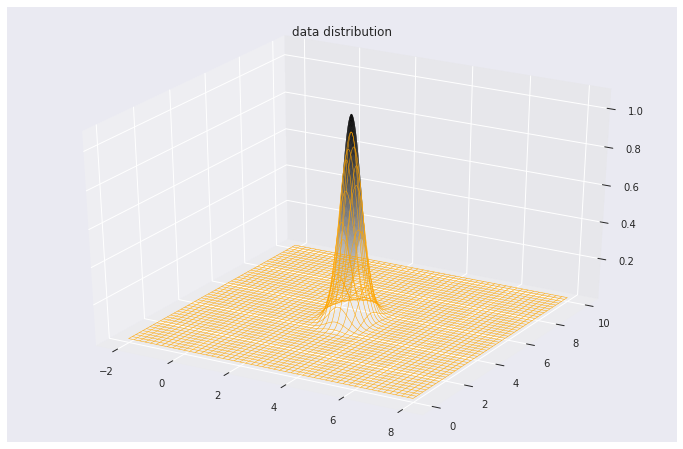

In [498]:
real_mu = np.array([3,5])
real_sigma_inv = np.array([[10,2],
                       [2,5]])
pre_sigma_nu = 3
pre_sigma_w = np.array([[1,0],
                        [0,1]])

pre_mu_loc = np.array([0,0])
pre_mu_beta = 1

data_size = 1000
D = 2

ax = draw_3d_distribution(data_size,(real_mu, real_sigma_inv),
                          distribution="norm",
                          cmap="gist_gray_r",
                          seed=3,
                          need_data=False)
# x_data.shape=(data_size,D)

# 平均のパラメーター更新
est_mu_beta = data_size+pre_mu_beta
est_mu_loc = (np.sum(x_data,axis=0)+pre_mu_beta*pre_mu_loc)/est_mu_beta

# 精度のパラメーター更新
est_sigma_nu = data_size + pre_sigma_nu
_m1 = np.dot(x_data.T,x_data)
_m2 = pre_mu_beta*np.dot(pre_mu_loc.reshape(D,-1),pre_mu_loc.reshape(-1,D))
_m3 = -est_mu_beta*np.dot(est_mu_loc.reshape(D,-1),est_mu_loc.reshape(-1,D))
est_sigma_w = np.linalg.inv(_m1+_m2+_m3+np.linalg.inv(pre_sigma_w))

print("---------")
print("estimated value:")
print("m=",est_mu_loc)
print("β=",est_mu_beta)
print("ν=",est_sigma_nu)
print("W=",est_sigma_w)
print("|W|=",np.linalg.det(est_sigma_w))

est_data_mu = est_mu_loc
est_data_nu = 1-D+est_sigma_nu
est_data_lam = (est_data_nu)*est_mu_beta*est_sigma_w/(1+est_mu_beta)
print(np.linalg.det(est_data_lam))
ax=draw_3d_distribution(data_size, (est_data_mu, est_data_lam, est_data_nu), ax=ax,cmap="orange",distribution="student")